In [61]:
#import package
import numpy as np
import matplotlib.pyplot as plt

In [80]:
#Input data and construct design matrix A and target vector b
print('Enter the path and name of a file which consists of data points: ')
path = input()

print('Enter the number of polynomial bases n: ')
num_polyBase = input()
num_polyBase = int(num_polyBase)

print('Enter lambda: ')
Lambda = input()
Lambda = float(Lambda)


data = []
with open(path, 'r') as file:
    for data_point in file:
        x, y = data_point.strip().split(',')
        data.append((float(x),float(y)))

#construct design matrix A
A = np.zeros((len(data),num_polyBase))
for i in range(A.shape[0]):
    value = 1
    for j in range(A.shape[1]):
        A[i][A.shape[1] - 1 - j] = value
        value *= data[i][0]

#consturct target vector b
b = np.zeros((len(data),1))
for i in range(len(data)):
    b[i][0] = data[i][1]


Enter the path and name of a file which consists of data points: 
/content/data
Enter the number of polynomial bases n: 
3
Enter lambda: 
10000


In [81]:
#Some useful function

#get matrix transpose
def matrix_transpose(A):
    A_trans = np.zeros((A.shape[1],A.shape[0]))
    for i in range(A_trans.shape[0]):
        for j in range(A_trans.shape[1]):
            A_trans[i][j] = A[j][i]
    return A_trans

#get the result of matrix multiplication A, B
def matrix_mul(A, B):
    result = np.zeros((A.shape[0],B.shape[1]))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            value = 0
            for k in range(A.shape[1]):
                value += A[i][k]*B[k][j]
            result[i][j] = value
    return result

#get inverse of matrix A from LU decomposition
def get_inverse(A):
    U = np.copy(A) #U is deep copy of matrix A
    L = np.eye(A.shape[0]) #get identity matrix
    for i in range(A.shape[0]-1):
        L_i = np.eye(A.shape[0])
        for j in range(i + 1, A.shape[0]):
            L_i[j][i] = -(U[j][i] / U[i][i])
            L[j][i] = U[j][i] / U[i][i]
        U = matrix_mul(L_i, U)

    #Next, compute L_inv
    L_inv = np.zeros(A.shape)
    for i in range(L_inv.shape[0]):
        for j in range(L_inv.shape[1]):
            temp = 0
            for k in range(j):
                temp += L[j][k]*L_inv[k][i]
            if i == j:
                L_inv[j][i] = (1 - temp) / L[j][j]
            else:
                L_inv[j][i] = (0 - temp) / L[j][j]

    #Next, compute U_inv
    U_inv = np.zeros(A.shape)
    for i in range(U_inv.shape[0]):
        for j in range(U_inv.shape[1] - 1, -1, -1):
            temp = 0
            for k in range(U_inv.shape[1]-1, j, -1):
                temp += U[j][k]*U_inv[k][i]
            if i == j:
                U_inv[j][i] = (1 - temp) / U[j][j]
            else:
                U_inv[j][i] = (0 - temp) / U[j][j]

    A_inv = matrix_mul(U_inv,L_inv)
    return A_inv

def L1_norm(A,B):
    value = 0
    for i in range(len(A)):
        value += abs(A[i][0]-B[i][0])
    return value

#given function parameter and point x, compute f(x)
def f(par,x):
    value = 0
    temp = 1
    for j in range(par.shape[0]):
        value += par[par.shape[0] - 1 - j][0] * temp
        temp *= x
    return value

# Closed-form LSE approach

From Lecture, we can know that the optimal solution for   $min_w E(w) = \sum_{i}{(y_i(x_i,w)-b_i)^2}+\lambda*\lVert w \rVert^2 $

is $w = (A^TA+\lambda I)^{-1}A^Tb$

We can note that $(A^TA+\lambda I)$ is positive-definite, so it always invertible.

LSE:
Fitting line: 0.834533282700286X^2 + 0.09314819831918814X^1 + 0.04695069927346928
Total_error: 22649.738493024146


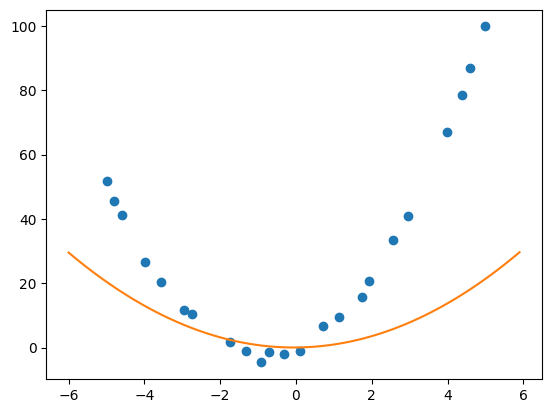

In [82]:
#According to the lecture formula, optimal x = (A^T*A+lamda*I)^-1*A^T*b
A_trans = matrix_transpose(A)
temp = matrix_mul(A_trans,A) + Lambda * np.eye(A.shape[1])
par = get_inverse(temp)
par = matrix_mul(par,A_trans)
par = matrix_mul(par,b)

#draw and print results
xpoints, ypoints = zip(*data)
x = np.arange(min(xpoints) - 1,max(xpoints) + 1,0.1)

y = []
for i in range(len(x)):
    y.append(f(par,x[i]))

Total_error = 0
for i in range(len(xpoints)):
    Total_error += (f(par,xpoints[i]) - ypoints[i])**2

print("LSE:")
s = ""
for i in range(par.shape[0]):
    if i == par.shape[0]-1:
        s += str(par[i][0])
    else:
        s += str(par[i][0]) + "X^{} ".format(par.shape[0]-1-i) + "+ "
print("Fitting line: {}".format(s))
print("Total_error: {}".format(Total_error))

plt.plot(xpoints, ypoints, 'o')
plt.plot(x,y)
plt.show()

# For Newton's method

From Lecture, we have iterative formula to find the root(i.e.$f(x)=0$):

$x_{n+1}= x_n - \frac{f'(x_n)}{f''(x_n)}$

If dimension of $x_n$ is larger than 1, then we have

$x_{n+1}= x_n - Hf(x_n)^{-1}\nabla f(x_n)$ , where $H$ is Hession matrix.

If we set $f(x) = \lVert Ax-b \rVert^2$ and we want to find $x^* = \mathop{\arg\min}\limits_{x} f(x)$.

From Lecture, we have $\nabla f(x_n)=2A^TAx_n-2A^Tb$ and $Hf(x_n)=2A^TA$

Implement detail:

We iteratively apply a formula to calculate $x_{n+1}$ from $x_n$ until $x_{n+1}$ is sufficiently close to $x_n$ (i.e., $\lVert x_{n+1} - x_n \rVert < \epsilon$).

Newton's Method: 
Fitting line: 3.0238533934865712X^2 + 4.906190263863798X^1 + -0.23140175608772742
Total_error: 26.559959499333047


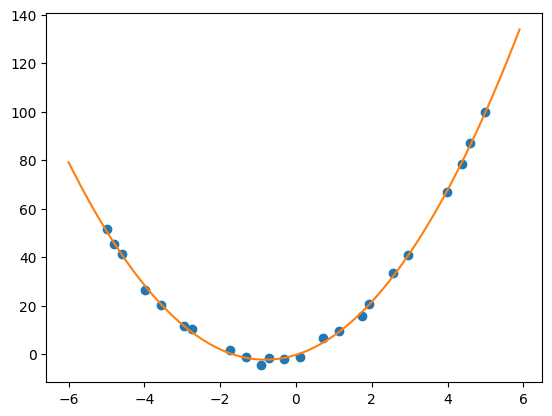

In [83]:
eps = 10e-6
Hession = 2 * matrix_mul(A_trans,A)
Hession_inv = get_inverse(Hession)

x = np.ones((num_polyBase,1))
newx = np.zeros((num_polyBase,1)) #initilize point

while(L1_norm(newx,x) >= eps):
    x = newx
    grad = x
    grad = matrix_mul(A,grad)
    grad = matrix_mul(A_trans,grad)
    grad = 2*grad
    grad = grad - 2*matrix_mul(A_trans,b)
    newx = x - matrix_mul(Hession_inv,grad)

par = newx

#draw and print results
xpoints, ypoints = zip(*data)
x = np.arange(min(xpoints) - 1,max(xpoints) + 1,0.1)


y = []
for i in range(len(x)):
    y.append(f(par,x[i]))

Total_error = 0
for i in range(len(xpoints)):
    Total_error += (f(par,xpoints[i]) - ypoints[i])**2

print("Newton's Method: ")
s = ""
for i in range(par.shape[0]):
    if i == par.shape[0] - 1:
        s += str(par[i][0])
    else:
        s += str(par[i][0]) + "X^{} ".format(par.shape[0]-1-i) + "+ "
print("Fitting line: {}".format(s))
print("Total_error: {}".format(Total_error))

plt.plot(xpoints, ypoints, 'o')
plt.plot(x,y)
plt.show()


# Steepest descent method with L1-norm

By Steepest descent method, we can iterative use formula $x_{n+1}=x_n- \alpha *\nabla L(x_n)$ to get $x^* = \mathop{\arg\min}\limits_{x} L(x)$ , where $\alpha$ is learning rate.

If we set Loss function $L(x) = \lVert Ax-b \rVert = \sum_{i} |\sum_{j}a_{ij}x_{j}-b_i|$ , then $\nabla L(x)=
\left (\begin{array}{rrrr}
\hat{x}_1\\
\hat{x}_2\\
...\\
\hat{x}_n
\end{array}\right)$
,where $\hat{x}_i=\sum_{j}sign(a_{ij}x_{j}-b_i)*a_{ij}$

Additionally, we specify the following hyperparameters:

*   Learning Rate: 0.0001
*   Maximum Number of Iterations (Max Epoch): 2000


Steepest descent method with L1_norm: 
Fitting line: 3.021330695543623X^2 + 4.8705918367349765X^1 + -0.09700000000000157
Total_error: 27.155118692741038


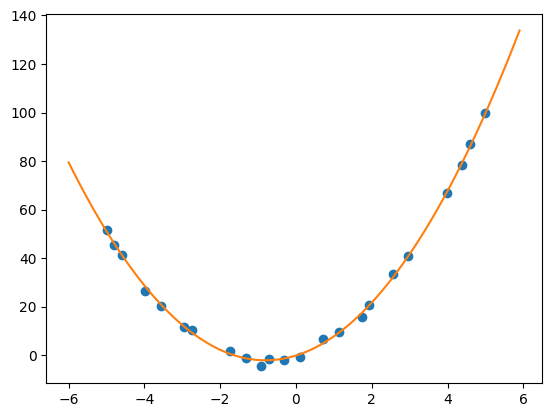

In [84]:
#steepest descent method(L1 norm):
lr = 0.0001
max_epoch = 2000

x = np.zeros((num_polyBase,1)) #initilize point

for i in range(max_epoch):
    cur = matrix_mul(A,x) - b
    grad = np.zeros((num_polyBase,1))
    for i in range(num_polyBase):
        for j in range(len(data)):
            if cur[j] >= 0:
                grad[i][0] += A[j][i]
            else:
                grad[i][0] -= A[j][i]
    x = x - lr * grad

par = x

#draw and print results
xpoints, ypoints = zip(*data)
x = np.arange(min(xpoints) - 1,max(xpoints) + 1,0.1)

y = []
for i in range(len(x)):
    y.append(f(par,x[i]))

Total_error = 0
for i in range(len(xpoints)):
    Total_error += (f(par,xpoints[i]) - ypoints[i])**2

print("Steepest descent method with L1_norm: ")
s = ""
for i in range(par.shape[0]):
    if i == par.shape[0] - 1:
        s += str(par[i][0])
    else:
        s += str(par[i][0]) + "X^{} ".format(par.shape[0]-1-i) + "+ "
print("Fitting line: {}".format(s))
print("Total_error: {}".format(Total_error))

plt.plot(xpoints, ypoints, 'o')
plt.plot(x,y)
plt.show()

# Steepest descent method with LSE

We set the loss function as $L(x) = \lVert Ax - b \rVert^2 = \sum_{i} |\sum_{j}a_{ij}x_{j} - b_i|^2$. The gradient is same to Newton's method, we have $\nabla L(x) = 2A^TAx - 2A^Tb$.

Additionally, we specify the following hyperparameters:

*   Learning Rate: 0.0001
*   Maximum Number of Iterations (Max Epoch): 2000

Steepest descent method with LSE: 
Fitting line: 3.0234732444507424X^2 + 4.906177899398839X^1 + -0.22468061642338633
Total_error: 26.560424808916522


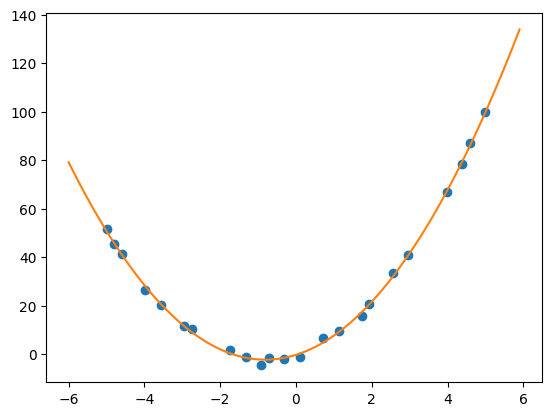

In [85]:
#steepest descent method(LSE):
lr = 0.0001
max_epoch = 2000

x = np.zeros((num_polyBase,1)) #initilize point

for i in range(max_epoch):
    grad = x
    grad = matrix_mul(A,grad)
    grad = matrix_mul(A_trans,grad)
    grad = 2*grad - 2*matrix_mul(A_trans,b)
    x = x - lr * grad

par = x

#draw and print results
xpoints, ypoints = zip(*data)
x = np.arange(min(xpoints) - 1,max(xpoints) + 1,0.1)

y = []
for i in range(len(x)):
    y.append(f(par,x[i]))

Total_error = 0
for i in range(len(xpoints)):
    Total_error += (f(par,xpoints[i]) - ypoints[i])**2

print("Steepest descent method with LSE: ")
s = ""
for i in range(par.shape[0]):
    if i == par.shape[0] - 1:
        s += str(par[i][0])
    else:
        s += str(par[i][0]) + "X^{} ".format(par.shape[0]-1-i) + "+ "
print("Fitting line: {}".format(s))
print("Total_error: {}".format(Total_error))

plt.plot(xpoints, ypoints, 'o')
plt.plot(x,y)
plt.show()